In [1]:
import collections
import bisect
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.signal as signal

from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import KFold




sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.0, 'lines.markersize': 5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

tw = 1.5
sns.set_style({"xtick.major.size": 6, "ytick.major.size": 6,
               "xtick.minor.size": 4, "ytick.minor.size": 4,
               'axes.labelsize': 24,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18)
mpl.rc('axes', linewidth=1.75)
plt.gcf().subplots_adjust(bottom=0.15)
sns.set_style({'axes.labelsize': 24})


%matplotlib inline
# This enables high res graphics inline
%config InlineBackend.figure_format = 'svg'

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def get_values(file_directory, channel='GFP/FITC-A'):
    ''' Reads in the values from a specific channel for a given flow file.
    Defaults to taking GFP/FITC-A.'''
    flow_data = pd.read_csv(file_directory)
    flow_data_gfp_values = np.log10(flow_data[channel].values)
    return flow_data_gfp_values

In [1]:
def make_df(file_directory, channel='GFP/FITC-A'):
    '''Creates a dataframe from the given file directory. Reads in all csvs, 
    extracts the data from the channel of interest (defaults to GFP/FITC-A), 
    and returns one dataframe.'''
    all_files = glob.glob(file_directory)
    all_files.sort()
    
    all_data = []
    for file in all_files:
        data = get_values(file, channel)
        all_data.append(data)
    
    labels = []
    for i in range(0, len(all_files)):
        mini_label = str(all_files[i].split('.')[2][-3:])
        label = [mini_label]*len(all_data[i])
        labels.append(label)
    
    flat_all_data = [item for sublist in all_data for item in sublist]
    flat_labels = [item for sublist in labels for item in sublist]
    
    df = pd.DataFrame(dict(well=flat_labels, log10GFP=flat_all_data))
    return df
        

In [4]:
def get_peak_locations_from_KDE_fit(data):
    ''' Performs a KDE fit and then uses scipy.signal.find_peaks_cwt to get peaks.
        The KDE bandwith parameter is critical, and 0.25 has worked well in the past.
        If it feels like you are missing many peak calls, decrease the bandwith. If it feels
        like you are having too many peak calls, increase the bandwith. 
        
        Don't change the bandwith without good reason, it took awhile to decide on 0.25. '''
    
    kde = KernelDensity(bandwidth=0.25, kernel='gaussian')
    kde.fit(data[:, None]);

    x_range = np.linspace(0, 6, 1200)
    kde_estimates = np.exp(kde.score_samples(x_range[:, None]))

    #Use the SciPy function to get the KDE peaks
    peaks = signal.find_peaks_cwt(kde_estimates, np.arange(30, 200), min_snr=1)

    means_init = []
    
    for peak in peaks:
        means_init.append(x_range[peak])
    
    return means_init

In [5]:
def fit_GMM_KDE(data, peaks, threshold = 0.01): 
    """Generate a Gaussian mixture model from the output
    of a Gaussian Kernel Density Estimation. 
    Outputs the mean of the on peak, fraction on, mean of the off peak, 
    and fraction off. This version of the code assumes all cells not in the on peak are off!
    This is obviously only a good assumption for uni/bimodal data. If you have multimodal data,
    do not use this code."""
    
    data = data.reshape(len(data), 1)
    
    peaks = np.array(peaks).reshape(len(peaks), 1)
    opt_gmm = GaussianMixture(n_components = len(peaks) , means_init = peaks).fit(data)  
    
    labels = opt_gmm.predict(data)
    labels = np.ravel(labels.reshape(len(labels), 1))

    means = opt_gmm.means_

    df = pd.DataFrame({'gfp': np.ravel(data), 'distribution': labels})
    
    df.head(10)
    counts = []
    means = []
    
    
    
    for i in range(0, len(peaks)):
        df_distro = df.loc[df['distribution']==i]
        counts.append(len(df_distro))
        means.append(np.mean(df_distro['gfp'].values))

    print('counts = ', counts)
    print('means = ', means)
    total = len(df)
    
    fractions = np.array(counts)/total
    
    ##Initializing corrected lists of means and fractions of subpopulations
    GMM_accepted_means = []
    
    GMM_corrected_fractions = []
    
    for i in range(0, len(fractions)):
        if fractions[i] > threshold: 
            GMM_accepted_means.append(means[i])
            GMM_corrected_fractions.append(fractions[i])    

    index_of_on = GMM_accepted_means.index(max(GMM_accepted_means))
    
    fraction_of_highest_peak = GMM_corrected_fractions[index_of_on]
    
    fraction_off = 1 - fraction_of_highest_peak
    
    mean_of_highest_peak = GMM_accepted_means[index_of_on]
    
    weighted_peak_means = []
    for i in range(0, len(GMM_corrected_fractions)):
        if i == index_of_on:
            pass
        else: 
            weighted_mean = GMM_corrected_fractions[i] * np.power(10, GMM_accepted_means[i])
            weighted_peak_means.append(weighted_mean)
    
    mean_of_off_population = np.log10(np.mean(weighted_peak_means))
    
    return mean_of_highest_peak, fraction_of_highest_peak, mean_of_off_population, fraction_off



In [6]:
def fit_GMM_KDE_wrapper (data):
    """Wrapper function to get both the peaks from a KDE fit, and then 
    from the Gaussian mixture model. Returns the mean of the broken cells, 
    and the fraction of broken cells."""
    
    peak_locations= get_peak_locations_from_KDE_fit(data)
    
    mean_of_highest_peak, fraction_of_highest_peak, mean_of_off_population, fraction_off = fit_GMM_KDE(data, peak_locations, threshold = 0.01)
    
    return mean_of_highest_peak, fraction_of_highest_peak, mean_of_off_population, fraction_off

In [7]:
def GMM_method(df_, wells):
    '''Wrapper function for the the entire generation of the final output df. 
    Takes the input dataframe and a list of all wells you want to perform GMM fitting on.
    '''
    means_on = []
    fractions_on = []
    means_off = []
    fractions_off = []
    wells_df = []
    
    for well in wells:
        data = df_.loc[df_['well'] == well]
        
        YFP = data['log10GFP'].values
        
        mean_of_highest_peak, fraction_of_highest_peak, mean_of_off_population, \
                        fraction_off = fit_GMM_KDE_wrapper(YFP)
        
        means_on.append(mean_of_highest_peak)
        fractions_on.append(fraction_of_highest_peak)
        means_off.append(mean_of_off_population)
        fractions_off.append(fraction_off)
        wells_df.append(well) 

    plt_df = pd.DataFrame({'mean ON': means_on, 'fraction ON' : fractions_on,
                           'mean OFF':means_off, 'fraction OFF' : fractions_off,
                           'well': wells_df})
    
    return plt_df

In [8]:
# Initialize the list of wells that you have data files for and wish to fit with GMMs
wells = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07',
         'C02', 'C03', 'C04', 'C05', 'C06', 'C07',
         'D02', 'D03', 'D04', 'D05', 'D06', 'D07',
         'E02', 'E03', 'E04', 'E05', 'E06', 'E07',
         'F02', 'F03', 'F04', 'F05', 'F06', 'F07',
         'G02', 'G03', 'G04', 'G05', 'G06', 'G07',
         'B08', 'C08', 'D08', 'E08', 'F08', 'G08',
         'B09', 'C09', 'D09', 'E09', 'F09', 'G09',
         'B10', 'C10', 'D10', 'E10', 'F10', 'G10',
         'B11', 'C11', 'D11', 'E11', 'F11', 'G11']

In [16]:
#Read in the tidied data generated by "ADH_automatic_flow_gating_and_well_labeling.ipynb"
# The input for make_df is the directory that you want automatic fractions generated for. 
input_df = make_df('../Data/example_data/gated_scatter/*.csv')
input_df = input_df.dropna()

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


In [17]:
# Generate an output_df by running GMM method. The inputs are the input_df and
# the list of all wells you want generated
output_df = GMM_method(input_df, wells)

counts =  [3192, 2766]
means =  [1.8313760902185658, 2.8452534032871668]
counts =  [4651, 1735]
means =  [2.0006729376708994, 3.0254389717138035]
counts =  [4837, 601]
means =  [1.6132444631731158, 3.570500690162687]
counts =  [884, 5887]
means =  [1.4813879432677552, 3.3853924292981263]
counts =  [5203, 890]
means =  [1.7625092448027817, 0.82621860925744361]
counts =  [3171, 2468]
means =  [1.7073173739271488, 3.0714943068323715]
counts =  [59, 7679]
means =  [1.8355767017510252, 3.1731739499701628]


/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


counts =  [6506]
means =  [2.3385666931519995]
counts =  [7644]
means =  [3.1411286404004395]
counts =  [1708, 4343]
means =  [1.5099164966207055, 3.1296179249700016]
counts =  [22, 7557]
means =  [1.8687314697246236, 3.142986361414065]
counts =  [26, 894, 5998]
means =  [-0.15498603385925674, 1.6860050245715847, 3.3429322005284923]
counts =  [6931]
means =  [2.6851592158979525]
counts =  [5238]
means =  [1.6832937547123861]
counts =  [352, 6958]
means =  [1.5060480768575337, 3.1485638122695412]
counts =  [5039, 513]
means =  [1.6003472051783281, 3.0752352342504135]
counts =  [29, 7575]
means =  [1.8452329776671115, 3.0825396092601078]
counts =  [5465, 138]
means =  [1.6033923795801592, 3.077765589162277]
counts =  [7194]
means =  [2.5848996500426642]
counts =  [7001]
means =  [2.3123465472127007]
counts =  [1865, 3068, 945]
means =  [1.5476420571516125, 3.0435551123419038, 3.9192925832407424]
counts =  [1678, 5853]
means =  [2.5176112513504374, 3.5166210761180654]
counts =  [4174, 172

In [18]:
# Check the output to make sure it looks correct
output_df.head(10)

,fraction OFF,fraction ON,mean OFF,mean ON,well
0,0.535750,0.464250,1.560338,2.845253,B02
1,0.728312,0.271688,1.862990,3.025439,B03
2,0.889481,0.110519,1.562381,3.570501,B04
3,0.130557,0.869443,0.597187,3.385392,B05
4,0.146069,0.853931,-0.009223,1.762509,B06
5,0.562334,0.437666,1.457312,3.071494,B07
6,0.007625,0.992375,NaN,3.173174,C02
7,0.000000,1.000000,NaN,2.338567,C03
8,0.000000,1.000000,NaN,3.141129,C04
9,0.282267,0.717733,0.960577,3.129618,C05


In [13]:
# Write the output file to a csv. 
output_df.to_csv('../Data/example_data/GMM_flow_test.csv', index = False)

Below is code to check if the output from the fitting process matches what a KDE plot of a given well looks like 

In [27]:
# Pick which well 
input_df_well = input_df.loc[(input_df['well'] == 'C02')]

YFP_values = input_df_well['log10GFP'].values

No handles with labels found to put in legend.


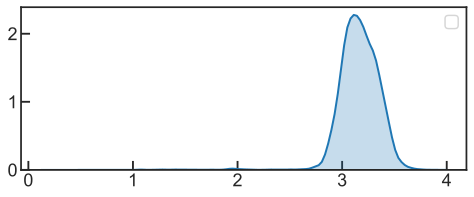

In [28]:
plt.figure(figsize =(8,3))
sns.kdeplot(YFP_values,  shade= True)
plt.legend()